<a href="https://colab.research.google.com/github/sheikhi-a/Big-data-with-Python/blob/main/spark_Kmeans_parallel_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Spark parallel kmeans

By Ayyub Sheikhi, SBUK  (sheikhy.a@uk.ac.ir)

In [ ]:

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq



In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"



In [ ]:

from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()


print(spark)
spark


In [ ]:
spark

In [ ]:
#SparkContext is created by default with the variable name sc
sc = spark.sparkContext
sc

In [ ]:
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

#print (pyspark.__version__)

In [ ]:
#running spark default settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs

%matplotlib inline

In [ ]:
# Data Frame spark profiling
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf


# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#Initializing File Type
file_type = 'text'
path=r'Mall_Customers.csv'
delimeter=','
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
        .option("delimeter",delimeter)\
        .option("inferSchema", "true") \
        .csv(path)
    else:
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df
df = load_data(file_type)
help(load_data)

load_data(file_type)


Help on function load_data in module __main__:

load_data(file_type)
    input type of file "text" or "parquet" and Return pyspark dataframe



DataFrame[CustomerID: int, Genre: string, Age: int, Annual Income (k$): int, Spending Score (1-100): int]

In [ ]:
#another way to read the but we dont run it
df0=spark.read.csv('Mall_Customers.csv', header=True)


In [ ]:
type(df)
pyspark.sql.dataframe.DataFrame
#show 5 observation in DataFrame
df.show(3)

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
+----------+------+---+------------------+----------------------+
only showing top 3 rows



In [ ]:
df.printSchema()

df=df.withColumnRenamed('CustomerID','Id')
df=df.withColumnRenamed('Annual Income (k$)','AnnIncome')
df=df.withColumnRenamed('Spending Score (1-100)','SpendScore')
df=df.withColumnRenamed('Genre','Gender')

len(df.columns), df.columns


root
 |-- CustomerID: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



(5, ['Id', 'Gender', 'Age', 'AnnIncome', 'SpendScore'])


3- Missing values detection

In [ ]:
df_pd=df.toPandas()
mis_val = df_pd.isnull().sum()
mis_valA = df_pd.AnnIncome.isnull().sum()

df_Nomiss=df.na.drop()
df_Nomiss.count()


df_Nomiss.groupBy('Gender').count()

df_Nomiss.groupBy('Gender').count().sort(col("count").desc()).show()

mode=df_Nomiss.groupBy('Gender').count().sort(col("count").desc()).collect()[0][0]
df.show()
df = df.na.fill({'Gender':mode})

df.describe().show()
df.select(mean('AnnIncome')).show()
meanvalue = df.select(mean('AnnIncome')).collect()[0][0]
df = df.na.fill({'AnnIncome':meanvalue})

meanvalue = df.select(mean('SpendScore')).collect()[0][0]
df = df.na.fill({'SpendScore':meanvalue})


+------+-----+
|Gender|count|
+------+-----+
|Female|  103|
|  Male|   84|
+------+-----+

+---+------+---+---------+----------+
| Id|Gender|Age|AnnIncome|SpendScore|
+---+------+---+---------+----------+
|  1|  Male| 19|       15|        39|
|  2|  Male| 21|       15|        81|
|  3|Female| 20|       16|         6|
|  4|Female| 23|       16|        77|
|  5|Female| 31|       17|        40|
|  6|  NULL| 22|       17|        76|
|  7|Female| 35|       18|         6|
|  8|  NULL| 23|     NULL|        94|
|  9|  Male| 64|       19|      NULL|
| 10|  NULL| 30|       19|        72|
| 11|  Male| 67|       19|        14|
| 12|Female| 35|       19|        99|
| 13|Female| 58|       20|      NULL|
| 14|  NULL| 24|       20|        77|
| 15|  Male| 37|       20|        13|
| 16|  Male| 22|       20|      NULL|
| 17|Female| 35|       21|        35|
| 18|  Male| 20|       21|        66|
| 19|  Male| 52|       23|        29|
| 20|Female| 35|       23|        98|
+---+------+---+---------+---------

Graphical representation for another preprocessing

In [ ]:
#Checking outliers

sns.boxplot(y="Age",data=df_pd2)
plt.show()


sns.boxplot(y="AnnIncome",data=df_pd2)
plt.show()


# Handle of outliers



In [ ]:
from pyspark.sql.functions import col, expr, percentile_approx


percentiles = df.select(
    percentile_approx("AnnIncome", 0.25).alias("Q1"),
    percentile_approx("AnnIncome", 0.75).alias("Q3")
).collect()

Q1 = percentiles[0]["Q1"]
Q3 = percentiles[0]["Q3"]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df.filter((col("AnnIncome") < lower_bound) | (col("AnnIncome") > upper_bound))

# Show results
outliers.show()
df_no_out= df.filter((col("AnnIncome") >lower_bound) & (col("AnnIncome") < upper_bound))
df_no_out.count()




df_no_out.describe().show()


+---+------+---+---------+----------+
| Id|Gender|Age|AnnIncome|SpendScore|
+---+------+---+---------+----------+
|199|  Male| 32|      137|        18|
|200|  Male| 30|      137|        83|
+---+------+---+---------+----------+

+-------+------------------+------+------------------+-----------------+-----------------+
|summary|                Id|Gender|               Age|        AnnIncome|       SpendScore|
+-------+------------------+------+------------------+-----------------+-----------------+
|  count|               198|   198|               198|              198|              198|
|   mean|              99.5|  NULL| 38.92929292929293|59.95454545454545|50.42424242424242|
| stddev|57.301832431432764|  NULL|14.016851732555248|25.03364141678589|25.15821647140652|
|    min|                 1|Female|                18|               15|                1|
|    max|               198|  Male|                70|              126|               99|
+-------+------------------+------+--------

# Perform K-means clustering

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Age", "AnnIncome"], outputCol="features")
feature_df = assembler.transform(df_no_out)
feature_df.show()

kmeans = KMeans(k=2, seed=1)  # Assume the number of clusters (k=2)
model = kmeans.fit(feature_df)

predictions = model.transform(feature_df)
predictions.show()

predictions.select("Id", "features", "prediction").show()
model.clusterCenters()


print("Cluster Centers: ", model.clusterCenters())






+---+------+---+---------+----------+-----------+
| Id|Gender|Age|AnnIncome|SpendScore|   features|
+---+------+---+---------+----------+-----------+
|  1|  Male| 19|       15|        39|[19.0,15.0]|
|  2|  Male| 21|       15|        81|[21.0,15.0]|
|  3|Female| 20|       16|         6|[20.0,16.0]|
|  4|Female| 23|       16|        77|[23.0,16.0]|
|  5|Female| 31|       17|        40|[31.0,17.0]|
|  6|Female| 22|       17|        76|[22.0,17.0]|
|  7|Female| 35|       18|         6|[35.0,18.0]|
|  8|Female| 23|       60|        94|[23.0,60.0]|
|  9|  Male| 64|       19|        50|[64.0,19.0]|
| 10|Female| 30|       19|        72|[30.0,19.0]|
| 11|  Male| 67|       19|        14|[67.0,19.0]|
| 12|Female| 35|       19|        99|[35.0,19.0]|
| 13|Female| 58|       20|        50|[58.0,20.0]|
| 14|Female| 24|       20|        77|[24.0,20.0]|
| 15|  Male| 37|       20|        13|[37.0,20.0]|
| 16|  Male| 22|       20|        50|[22.0,20.0]|
| 17|Female| 35|       21|        35|[35.0,21.0]|


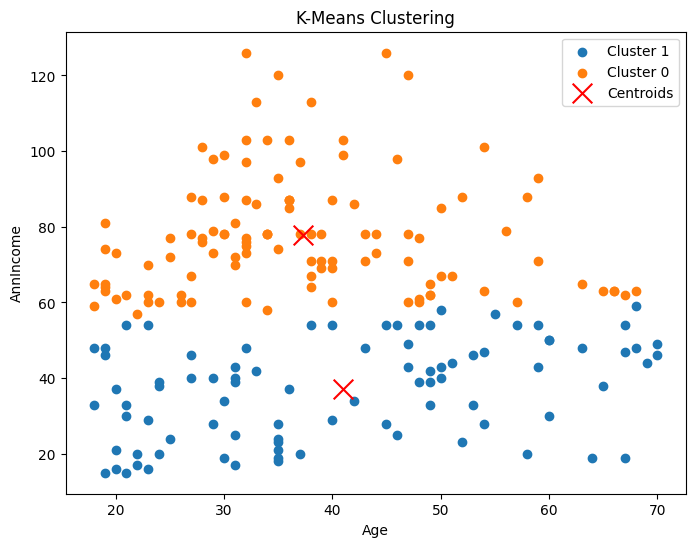

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = predictions.select("Age", "AnnIncome", "prediction").toPandas()

centers = model.clusterCenters()

centers_df = pd.DataFrame(centers, columns=["Age", "AnnIncome"])
centers_df.head()

plt.figure(figsize=(8, 6))
for cluster_id in pandas_df["prediction"].unique():
    cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
    plt.scatter(cluster_data["Age"], cluster_data["AnnIncome"], label=f"Cluster {cluster_id}")

plt.scatter(centers_df["Age"], centers_df["AnnIncome"], color='red', marker='x', s=200, label="Centroids")

plt.title("K-Means Clustering")
plt.xlabel("Age")
plt.ylabel("AnnIncome")
plt.legend()
plt.show()


In [ ]:
assembler = VectorAssembler(inputCols=["Age", "AnnIncome", 'SpendScore'], outputCol="features")
feature_df = assembler.transform(df_no_out)
feature_df.show()

kmeans = KMeans(k=2, seed=1)  # Assume the number of clusters (k=2)
model = kmeans.fit(feature_df)

predictions = model.transform(feature_df)
predictions.show()

# Step 6: Show Results
predictions.select("Id", "features", "prediction").show()
model.clusterCenters()


print("Cluster Centers: ", model.clusterCenters())



+---+------+---+---------+----------+----------------+
| Id|Gender|Age|AnnIncome|SpendScore|        features|
+---+------+---+---------+----------+----------------+
|  1|  Male| 19|       15|        39|[19.0,15.0,39.0]|
|  2|  Male| 21|       15|        81|[21.0,15.0,81.0]|
|  3|Female| 20|       16|         6| [20.0,16.0,6.0]|
|  4|Female| 23|       16|        77|[23.0,16.0,77.0]|
|  5|Female| 31|       17|        40|[31.0,17.0,40.0]|
|  6|Female| 22|       17|        76|[22.0,17.0,76.0]|
|  7|Female| 35|       18|         6| [35.0,18.0,6.0]|
|  8|Female| 23|       60|        94|[23.0,60.0,94.0]|
|  9|  Male| 64|       19|        50|[64.0,19.0,50.0]|
| 10|Female| 30|       19|        72|[30.0,19.0,72.0]|
| 11|  Male| 67|       19|        14|[67.0,19.0,14.0]|
| 12|Female| 35|       19|        99|[35.0,19.0,99.0]|
| 13|Female| 58|       20|        50|[58.0,20.0,50.0]|
| 14|Female| 24|       20|        77|[24.0,20.0,77.0]|
| 15|  Male| 37|       20|        13|[37.0,20.0,13.0]|
| 16|  Mal

We would like to compared to the speed of the traditional  Kmeans against the pyspark Kmeans

Following codes change the number of rules and number of attributes according to:

1000, 10

10000, 10

100000, 10

1000000, 10

100000, 100

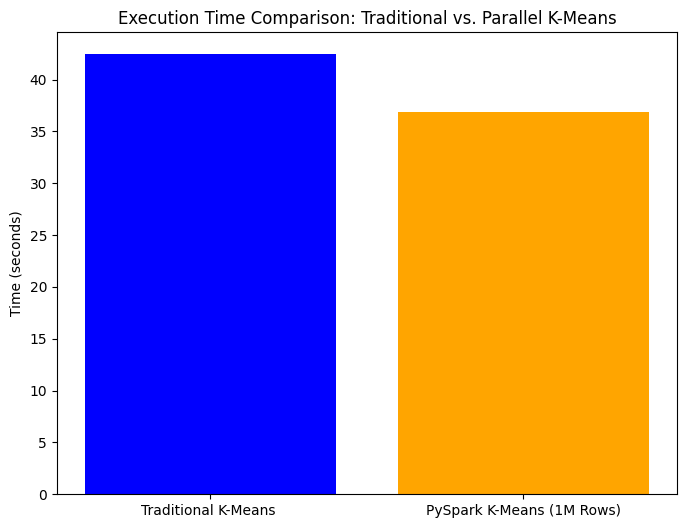

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Initialize SparkSession
spark = SparkSession.builder.appName("KMeansBenchmark").getOrCreate()

# Step 2: Generate a larger synthetic dataset
num_rows = 100000  # 1 million rows for a large dataset
num_features = 100   # 10 features
data = [(i, *[float(x) for x in np.random.rand(num_features)]) for i in range(num_rows)]
columns = ["id"] + [f"feature_{i}" for i in range(1, num_features + 1)]

df = spark.createDataFrame(data, columns)

# Step 3: Assemble features for clustering
assembler = VectorAssembler(inputCols=columns[1:], outputCol="features")
feature_df = assembler.transform(df).select("features")

# Step 4: Run PySpark Parallel K-Means
start_time = time.time()

kmeans = KMeans(k=5, seed=42)  # Using 5 clusters
model = kmeans.fit(feature_df)

end_time = time.time()
pyspark_time = end_time - start_time
print(f"PySpark Parallel K-Means Time: {pyspark_time:.2f} seconds")

# Step 5: Convert to Pandas for Traditional K-Means
pandas_df = feature_df.limit(num_rows).select("features").rdd.map(lambda x: x[0].toArray()).collect()
pandas_data = np.array(pandas_df)  # Convert to NumPy array for efficient computation

# Step 6: Traditional K-Means Implementation
def traditional_kmeans(data, k, max_iter=100, tol=1e-4):
    """
    Basic implementation of the K-Means algorithm.
    :param data: np.array of shape (n_samples, n_features)
    :param k: Number of clusters
    :param max_iter: Maximum number of iterations
    :param tol: Convergence tolerance for centroid changes
    :return: Cluster labels and final centroids
    """
    n_samples, n_features = data.shape
    # Randomly initialize centroids
    np.random.seed(42)
    centroids = data[np.random.choice(n_samples, k, replace=False)]

    for i in range(max_iter):
        # Assign each point to the nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Compute new centroids
        new_centroids = np.array([data[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
            break
        centroids = new_centroids

    return labels, centroids

start_time = time.time()

labels, centroids = traditional_kmeans(pandas_data, k=5)

end_time = time.time()
traditional_time = end_time - start_time
print(f"Traditional K-Means Time: {traditional_time:.2f} seconds")

# Step 7: Compare Results and Calculate Speedup
speedup = traditional_time / pyspark_time
print(f"Speedup: {speedup:.2f}x")

# Step 8: Plot Results
methods = ["Traditional K-Means ", "PySpark K-Means "]
times = [traditional_time, pyspark_time]

plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'orange'])
plt.title("Execution Time Comparison: Traditional vs. Parallel K-Means")
plt.ylabel("Time (seconds)")
plt.show()


--2024-12-05 18:47:47--  https://raw.githubusercontent.com/CConstance/tweets_sentiment/master/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1346152 (1.3M) [text/plain]
Saving to: ‘test.csv.1’

test.csv.1          100%[===================>]   1.28M  --.-KB/s    in 0.01s   

2024-12-05 18:47:47 (131 MB/s) - ‘test.csv.1’ saved [1346152/1346152]

+-------------------+----------+--------+--------------------+--------------+-----------+
|                 id|      date|    time|               tweet|retweets_count|likes_count|
+-------------------+----------+--------+--------------------+--------------+-----------+
|1249857397839073291|2020-04-14|00:29:59|Could Coronavirus...|             0|          0|
|1249857397771862026|2020-04-14|00:29:59|[Get the In

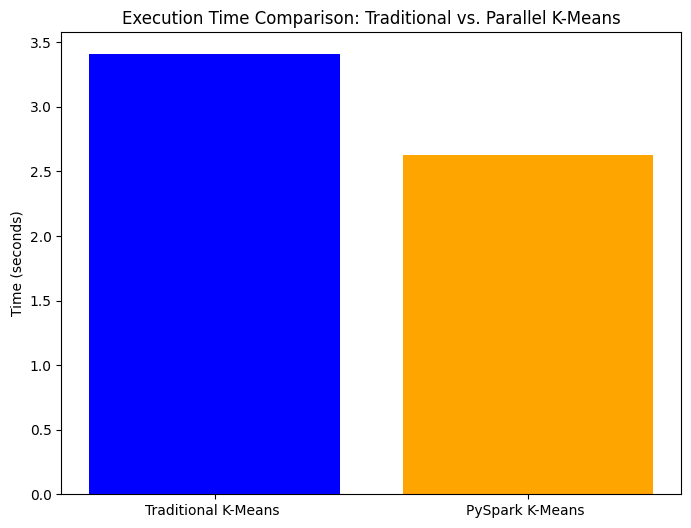

In [ ]:

!wget https://raw.githubusercontent.com/CConstance/tweets_sentiment/master/test.csv



df = pd.read_csv("test.csv")
df.shape
df.head(3)
df = spark.createDataFrame(df)

df.show()

# Step 3: Assemble features for clustering
assembler = VectorAssembler(inputCols=['retweets_count', 'likes_count'], outputCol="features")
feature_df = assembler.transform(df).select("features")

# Step 4: Run PySpark Parallel K-Means
start_time = time.time()

kmeans = KMeans(k=2, seed=42)  # Using 2 clusters
model = kmeans.fit(feature_df)

end_time = time.time()
pyspark_time = end_time - start_time
print(f"PySpark Parallel K-Means Time: {pyspark_time:.2f} seconds")





from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

start_time = time.time()

assembler = VectorAssembler(inputCols=["retweets_count", "likes_count"], outputCol="features")
feature_df = assembler.transform(df)
feature_df.show()

kmeans = KMeans(k=2, seed=1)  # Assume the number of clusters (k=2)
model = kmeans.fit(feature_df)

predictions = model.transform(feature_df)
predictions.show()

predictions.select("Id", "features", "prediction").show()
model.clusterCenters()


print("Cluster Centers: ", model.clusterCenters())



end_time = time.time()
traditional_time = end_time - start_time
traditional_time
# Step 7: Compare Results and Calculate Speedup
speedup = traditional_time / pyspark_time
print(f"Speedup: {speedup:.2f}x")

# Step 8: Plot Results
methods = ["Traditional K-Means ", "PySpark K-Means "]
times = [traditional_time, pyspark_time]

plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'orange'])
plt.title("Execution Time Comparison: Traditional vs. Parallel K-Means")
plt.ylabel("Time (seconds)")
plt.show()









In [ ]:
!wget https://github.com/AlessandroCorradini/University-of-California-San-Diego-Big-Data-Specialization/blob/master/04%20-%20Machine%20Learning%20with%20Big%20Data/big-data-4/minute_weather.csv.gz?raw=true
df2 = pd.read_csv("https://github.com/AlessandroCorradini/University-of-California-San-Diego-Big-Data-Specialization/blob/master/04%20-%20Machine%20Learning%20with%20Big%20Data/big-data-4/minute_weather.csv.gz?raw=true", compression='gzip')


df2.shape

df2.head(5)

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [ ]:
sc.stop()